In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData, UVCal
import corrcal
from pathlib import Path
import os
import astropy.constants as const
from hera_sim import Simulator
import warnings
from scipy.optimize import fmin_cg
from scipy.special import airy
from astropy import constants

Here are some operations we care about:
<br><br>
* Calculating $\chi^2 = d^\dagger C^{-1} d$<br>
  * Calculating $C^{-1} = \bigl(N + GC^{\rm sky}G^\dagger\bigr)^{-1}$<br>
    * Calculating $GC^{\rm sky}G^\dagger$<br>
      * The `SplitMat` class matrix multiplication handles this correctly.<br>
* Calculating $\nabla\chi^2 = \tilde{d}^\dagger \nabla C \tilde{d}$<br>
  * Calculating $\tilde{d} = C^{-1} d$<br>
    * The `SplitMat` and `SplitVec` classes handle this correctly.<br>
  * Calculating $\nabla C = \nabla G C^{\rm sky} G^\dagger + GC^{\rm sky} \nabla G^\dagger$<br>
    * Based on the arguments above, the `SplitMat` class should handle this correctly.
        * Need to construct the *complex* gain matrix and its derivatives first, though.

In [27]:
sample_file = "small.sum.true.uvh5"
uvdata = UVData()
uvdata.read(sample_file)

Telescope RIMEz calculation is not in known_telescopes.


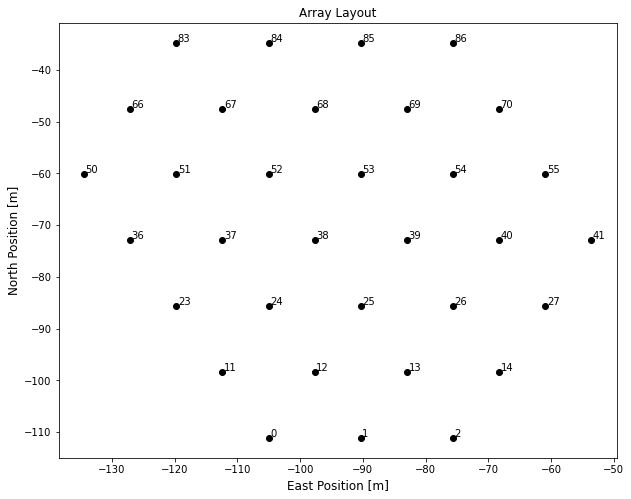

In [3]:
sim = Simulator(data=uvdata)
sim.plot_array();

In [4]:
uvdata.select(antenna_nums=np.array([67,68,69,37,38,39,11,12,13,52,53,24,25]), keep_all_metadata=False)

In [5]:
# Extract data/metadata for a single integration/channel.
t0 = uvdata.time_array[0]
nu0 = uvdata.freq_array.flatten()[0]
uvdata.select(times=np.array([t0]), frequencies=np.array([nu0]), polarizations=np.array(['xx']))

In [6]:
# Pull some metadata for slicing through the array
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
antpos, antnums = uvdata.get_ENU_antpos()
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

In [7]:
# Rather than use actual data, take a single source at a fixed position.
src_za = np.array([4 * np.pi / 5, 0 * np.pi / 3])
src_az = np.array([np.pi / 3, 5 * np.pi / 3])
src_flux = np.array([5, 2], dtype=float)
src_loc = np.array(
    [
        [np.sin(za)*np.cos(az), np.sin(za)*np.sin(az), np.cos(za)]
        for za, az in zip(src_za, src_az)
    ]
)
for i, (ai, aj) in enumerate(zip(ant_1_inds, ant_2_inds)):
    bl = antpos[aj] - antpos[ai]
    sim.data.data_array[i,...] = np.sum(
        src_flux * np.exp(
            -2j * np.pi * nu0 * src_loc @ bl / constants.c.si.value
        )
    )

In [8]:
Trx = np.min(src_flux) / 100
channel_width = np.median(sim.data.channel_width)
integration_time = np.median(sim.data.integration_time)
sim.add(
    "thermal_noise",
    Trx=Trx,
    omega_p=np.ones_like(sim.freqs)*2*np.pi,
    autovis=src_flux.sum(),
    channel_width=channel_width,
    integration_time=integration_time,
)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


In [9]:
uvdata.select(ant_str="cross")

In [10]:
# Pull the data array and the antenna metadata again.
data = uvdata.data_array[:,0,0,0].copy()
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
antpos, antnums = uvdata.get_ENU_antpos()
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

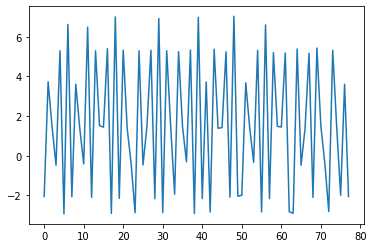

In [11]:
plt.plot(data.real)

In [12]:
# Sort the data into redundant groups.
wavelength = constants.c.si.value / nu0
uvws = (antpos[ant_2_inds] - antpos[ant_1_inds]) / wavelength
sort, edges, conj = corrcal.gridding.make_redundant_groups(*uvws.T[:2])
sorted_uvws = uvws[sort,:]
sorted_uvws[conj,:] *= -1
sorted_ant_1_inds = ant_1_inds[sort]
sorted_ant_2_inds = ant_2_inds[sort]
tmp = sorted_ant_1_inds.copy()
sorted_ant_1_inds[conj] = sorted_ant_2_inds[conj]
sorted_ant_2_inds[conj] = tmp[conj]
sorted_data = data[sort]
sorted_data[conj] = sorted_data[conj].conj()

In [13]:
# Insert a small amount of noise for invertibility.
Jy2T = 1e-26 * wavelength**2 / (2*constants.k_B.si.value*2*np.pi)
noise_amp = (src_flux.sum() + Trx/Jy2T)**2 / (channel_width*integration_time)
# noise_amp = 0.1
noise = np.eye(data.size, dtype=complex) * noise_amp
# noise = np.eye(data.size) * (1+1j) * noise_amp / 4

# Mock up a covariance matrix.
n_groups = edges.size - 1
n_bls = data.size
n_src = src_flux.size
diff_mat_amp = np.sum(src_flux)
diff_mat = np.zeros((n_bls, n_groups), dtype=complex)
for col, (start, stop) in enumerate(zip(edges, edges[1:])):
    diff_mat[start:stop,col] = diff_mat_amp
diff_cov = diff_mat @ diff_mat.T.conj()
bls = antpos[sorted_ant_2_inds] - antpos[sorted_ant_1_inds]
src_mat = src_flux.reshape(1, -1) * np.exp(
    -2j * np.pi * nu0 * bls @ src_loc.T / constants.c.si.value
)
src_cov = src_mat @ src_mat.T.conj()

# Now mock up antenna gains.
n_ants = antnums.size
err = 0.05
re_gain = np.random.normal(loc=1, scale=err, size=n_ants)
im_gain = np.random.normal(loc=0, scale=err, size=n_ants)
gains = re_gain + 1j*im_gain
gain_mat = gains[ant_1_inds] * gains[ant_2_inds].conj()
gain_mat = np.diag(gain_mat)

In [14]:
# First check: chi-squared is real-valued.
direct_chisq = sorted_data.T.conj() @ np.linalg.inv(
    noise + gain_mat @ (diff_cov + src_cov) @ gain_mat.T.conj()
) @ sorted_data
direct_chisq

(1390.6112696835469-8.292317943414673e-10j)

In [15]:
split_data = corrcal.linalg.SplitVec(sorted_data)
split_noise = corrcal.linalg.SplitMat(noise)
split_gain_mat = corrcal.linalg.SplitMat(gain_mat)
split_cov = corrcal.linalg.SplitMat(diff_cov + src_cov)
full_cov = split_noise + split_gain_mat @ split_cov @ split_gain_mat.conj()
cinv = np.linalg.inv(full_cov.real + 1j*full_cov.imag)
split_chisq = split_data.conj() @ corrcal.linalg.SplitMat(cinv) @ split_data
split_chisq

(1390.6112696826763-3.035438567167148e-10j)

In [16]:
# Now check that the chisq gradient is real-valued.
direct_chisq_gradient = np.zeros(2*n_ants, dtype=complex)
scaled_data = cinv @ sorted_data
for i in range(n_ants):
    for k in range(2):
        here = (slice(None,n_ants), slice(n_ants,None))[k]
        delta_a1_i = sorted_ant_1_inds == i
        delta_a2_i = sorted_ant_2_inds == i
        gain_mat_grad = np.zeros(n_bls, dtype=complex)
        if k == 0:
            gain_mat_grad[delta_a1_i] = re_gain[ant_2_inds][delta_a1_i] - 1j*im_gain[ant_2_inds][delta_a1_i]
            gain_mat_grad[delta_a2_i] = re_gain[ant_1_inds][delta_a2_i] + 1j*im_gain[ant_1_inds][delta_a2_i]
        else:
            gain_mat_grad[delta_a1_i] = im_gain[ant_2_inds][delta_a1_i] + 1j*re_gain[ant_2_inds][delta_a1_i]
            gain_mat_grad[delta_a2_i] = im_gain[ant_1_inds][delta_a2_i] - 1j*re_gain[ant_1_inds][delta_a2_i]
        gain_mat_grad = np.diag(gain_mat_grad)
        cov_grad = gain_mat_grad @ (src_cov+diff_cov) @ gain_mat.conj() + gain_mat @ (src_cov+diff_cov) @ gain_mat_grad.conj()
        direct_chisq_gradient[here][i] = scaled_data.conj() @ cov_grad @ scaled_data

In [17]:
# Now let's confirm we get similar results using the split formalism
split_chisq_gradient = np.zeros(2*n_ants, dtype=float)
split_cinv = full_cov.inv()
scaled_data = split_cinv @ split_data
for i in range(n_ants):
    for k in range(2):
        here = (slice(None,n_ants), slice(n_ants,None))[k]
        delta_a1_i = sorted_ant_1_inds == i
        delta_a2_i = sorted_ant_2_inds == i
        gain_mat_grad = np.zeros(n_bls, dtype=complex)
        if k == 0:
            gain_mat_grad[delta_a1_i] = re_gain[ant_2_inds][delta_a1_i] - 1j*im_gain[ant_2_inds][delta_a1_i]
            gain_mat_grad[delta_a2_i] = re_gain[ant_1_inds][delta_a2_i] + 1j*im_gain[ant_1_inds][delta_a2_i]
        else:
            gain_mat_grad[delta_a1_i] = im_gain[ant_2_inds][delta_a1_i] + 1j*re_gain[ant_2_inds][delta_a1_i]
            gain_mat_grad[delta_a2_i] = im_gain[ant_1_inds][delta_a2_i] - 1j*re_gain[ant_1_inds][delta_a2_i]
        gain_mat_grad = corrcal.linalg.SplitMat(np.diag(gain_mat_grad))
        cov_grad = gain_mat_grad @ split_cov @ split_gain_mat.conj() + split_gain_mat @ split_cov @ gain_mat_grad.conj()
        split_chisq_gradient[here][i] = np.real(scaled_data.conj() @ cov_grad @ scaled_data)

In [18]:
direct_chisq_gradient.real

array([  860.12941411, -2498.91535637,    10.01345401,  1485.39162986,
        -249.66407172,  1360.03407141,   709.25182323,  1471.65591083,
        -401.08262342,   156.07753845,   265.77663399, -1707.11563638,
        1180.22359572,    40.90214071,  1161.48693421, -1559.66671222,
        -504.65639735,   352.3725543 ,  -287.02323731,  1055.64234832,
         752.10463   ,  -673.29684845,  -270.44434329,    77.11827052,
         -93.21740045,  -331.89530556])

In [19]:
split_chisq_gradient

array([  860.12941411, -2498.91535633,    10.01345401,  1485.39162983,
        -249.66407171,  1360.0340714 ,   709.25182322,  1471.65591082,
        -401.08262342,   156.07753845,   265.77663398, -1707.11563636,
        1180.22359569,    40.90214071,  1161.48693419, -1559.66671219,
        -504.65639733,   352.37255429,  -287.02323732,  1055.6423483 ,
         752.10462999,  -673.29684844,  -270.44434329,    77.11827052,
         -93.21740045,  -331.89530554])

In [20]:
np.allclose(direct_chisq_gradient.imag/direct_chisq_gradient.real, 0)

True

In [21]:
def nll(gains, data, noise, cov, ant_1_inds, ant_2_inds, norm="simple", scale=1, grad_scale=None, edges=None):
    """
    Simple negative log-likelihood.
    
    gains: Array of re/im split antenna gains.
    data: Array of real-imag split data (i.e. SplitVec form of data)
    noise: diagonal matrix containing noise variance
    cov: SplitMat form of full covariance
    ant_1_inds: index of the first antenna for each baseline in the data
    ant_2_inds: index of the second antenna for each baseline in the data
    norm: which normalization scheme to use
    scale: amount by which the gains have been scaled prior to calling this function
    """
    n_ants = gains.size // 2
    gains = gains[:n_ants] + 1j*gains[n_ants:]
    gains = gains / scale
    gain_mat = gains[ant_1_inds] * gains[ant_2_inds].conj()
    gain_mat = corrcal.linalg.SplitMat(np.diag(gain_mat))
    noise = corrcal.linalg.SplitMat(noise)
    assert all(isinstance(obj, corrcal.linalg.SplitMat) for obj in (gain_mat, noise, cov))
    assert isinstance(data, corrcal.linalg.SplitVec)
    cov = noise + gain_mat @ cov @ gain_mat.conj()
    cov = (cov + cov.T) * 0.5
    cinv = cov.inv()
    chisq = data.conj() @ cinv @ data
    if chisq.imag / chisq.real > 1e-8:
        warnings.warn("Chi-squared isn't purely real.")
    chisq = chisq.real
    if norm == "simple":
        # Normalize average gain to be unity.
        _norm = np.sum(gains.imag)**2 + np.sum(gains.real - 1)**2
    elif norm == "det":
        try:
            raise np.linalg.LinAlgError
            L = np.linalg.cholesky(cov.data)
            _norm = 2 * np.sum(np.log(np.diag(L)))
        except np.linalg.LinAlgError:
            _norm = 0.5 * np.log(np.linalg.det(cov.data))
    elif norm == "weighted":
        assert edges is not None
        wgts = np.zeros(n_ants, dtype=int)
        for ant in range(n_ants):
            for start, stop in zip(edges, edges[1:]):
                wgts[ant] += int(ant in set(ant_1_inds[start:stop]).union(ant_2_inds[start:stop]))
        _norm = np.average(gains.imag, weights=wgts)**2 + np.average(gains.real - 1, weights=wgts)**2
    else:
        _norm = 0
    return chisq + _norm

In [22]:
def grad_nll(gains, data, noise, cov, ant_1_inds, ant_2_inds, norm="simple", scale=1, grad_scale=1, edges=None):
    """
    Simple gradient of the negative log-likelihood.
    
    gains: array of per-antenna re/im split gains
    data: SplitVec representation of data
    noise: diagonal matrix of noise variance
    cov: SplitMat representation of sky covariance
    ant_1_inds: index of the first antenna for each baseline in the data
    ant_2_inds: index of the second antenna for each baseline in the data
    norm: which normalization scheme to use
    scale: amount by which the gains are scaled prior to calling the function
    """
    n_ants = gains.size // 2
    n_bls = ant_1_inds.size
    gains = gains[:n_ants] + 1j*gains[n_ants:]
    gains = gains / scale
    re_gain = gains.real
    im_gain = gains.imag
    gain_mat = gains[ant_1_inds] * gains[ant_2_inds].conj()
    gain_mat = corrcal.linalg.SplitMat(np.diag(gain_mat))
    noise = corrcal.linalg.SplitMat(noise)
    full_cov = noise + gain_mat @ cov @ gain_mat.conj()
    full_cov = (full_cov + full_cov.T) * 0.5
    cinv = full_cov.inv()
    scaled_data = cinv @ data
    nll_gradient = np.zeros(2*n_ants, dtype=float)
    _norm = 0
    for i in range(n_ants):
        for k in range(2):
            here = (slice(None,n_ants), slice(n_ants,None))[k]
            delta_a1_i = ant_1_inds == i
            delta_a2_i = ant_2_inds == i
            gain_mat_grad = np.zeros(n_bls, dtype=complex)
            if k == 0:
                gain_mat_grad[delta_a1_i] = re_gain[ant_2_inds][delta_a1_i] - 1j*im_gain[ant_2_inds][delta_a1_i]
                gain_mat_grad[delta_a2_i] = re_gain[ant_1_inds][delta_a2_i] + 1j*im_gain[ant_1_inds][delta_a2_i]
            else:
                gain_mat_grad[delta_a1_i] = im_gain[ant_2_inds][delta_a1_i] + 1j*re_gain[ant_2_inds][delta_a1_i]
                gain_mat_grad[delta_a2_i] = im_gain[ant_1_inds][delta_a2_i] - 1j*re_gain[ant_1_inds][delta_a2_i]
            gain_mat_grad = corrcal.linalg.SplitMat(np.diag(gain_mat_grad))
            cov_grad = gain_mat_grad @ cov @ gain_mat.conj() + gain_mat @ cov @ gain_mat_grad.conj()
            nll_gradient[here][i] = np.real(scaled_data.conj() @ cov_grad @ scaled_data)
            if norm == "simple":
                if k == 0:
                    _norm += 2 * (np.sum(gains.real) - n_ants) / n_ants
                else:
                    _norm += 2 * np.sum(gains.imag)
            elif norm == "det":
                _norm = cinv @ cov_grad
                _norm = np.diag(_norm.real).sum() + np.diag(_norm.imag).sum()
                nll_gradient[here][i] -= _norm
            elif norm == "weighted":
                assert edges is not None
                wgts = np.zeros(n_ants)
                for ant in range(n_ants):
                    for start, stop in zip(edges, edges[1:]):
                        wgts[ant] += int(ant in set(ant_1_inds[start:stop]).union(ant_2_inds[start:stop]))
                if k == 0:
                    _norm += 2 * wgts[i] * (np.average(gains.real, weights=wgts) - n_ants) / wgts.sum()
                else:
                    _norm += 2 * wgts[i] * np.average(gains.imag, weights=wgts) / wgts.sum()
    if norm in ("simple", "weighted"):
        nll_gradient -= _norm
    tmp = (nll_gradient[:n_ants] + 1j*nll_gradient[n_ants:]) / scale
    nll_gradient[:n_ants] = tmp.real
    nll_gradient[n_ants:] = tmp.imag
    return -nll_gradient * grad_scale

In [26]:
n_ants

13

In [25]:
grad_nll(corrcal.linalg.SplitVec(gain_scale*gains).data, *args)

array([ 0.25500487, -0.03866248, -0.07529014, -0.18946541,  0.61665173,
       -0.00346302,  0.03407297, -0.00086193, -0.43603919, -0.18733964,
        0.0933382 , -0.03115588, -0.20588137, -0.03232115,  0.10539833,
        0.21632962, -0.03865024, -0.23309357, -0.03104643,  0.00685128,
       -0.0140019 , -0.00425357,  0.01729293, -0.03032815,  0.01799476,
        0.04738089])

In [24]:
norm = "det"
amp = 10000
phs = 0 * np.pi / 4
gain_scale = amp * np.exp(1j * phs)
grad_scale = 1
args = (split_data, noise, split_cov, ant_1_inds, ant_2_inds, norm, gain_scale, grad_scale, edges)
# fit_gains, steps = fmin_cg(
#     nll,
#     corrcal.linalg.SplitVec(gain_scale*gains).data,
#     fprime=grad_nll,
#     args=args,
#     callback=corrcal.utils.rephase_to_ant,
#     maxiter=40,
#     retall=True,
# )

Text(0, 0.5, 'Gain Residual')

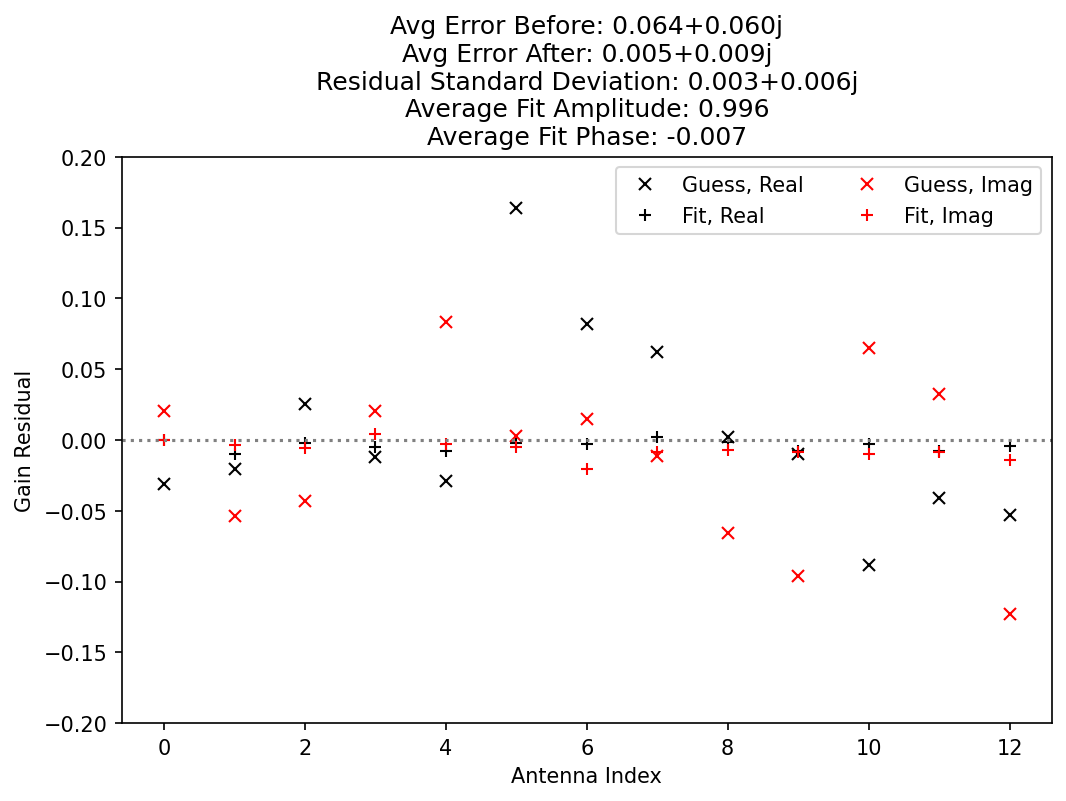

In [24]:
n_ants = gains.size
fit_gains = corrcal.utils.rephase_to_ant(fit_gains)
true_gains = corrcal.utils.rephase_to_ant(corrcal.linalg.SplitVec(gains).data)
fit = fit_gains[:n_ants] + 1j*fit_gains[n_ants:]
fit /= gain_scale
# fit /= np.abs(fit)
def err(val, exp):
    return np.sqrt(np.mean((val - exp)**2))
avg_err_before = err(gains.real, 1) + 1j*err(gains.imag, 0)
avg_err_after = err(fit.real, 1) + 1j*err(fit.imag, 0)
fit_std = np.std(fit.real) + 1j*np.std(fit.imag)
lim = 0.2
plt.figure(figsize=(8,5),dpi=150, facecolor='white')
title = f"Avg Error Before: {avg_err_before:.3f}\n"
title += f"Avg Error After: {avg_err_after:.3f}\n"
title += f"Residual Standard Deviation: {fit_std:.3f}\n"
title += f"Average Fit Amplitude: {np.mean(np.abs(fit)):.3f}\n"
title += f"Average Fit Phase: {np.mean(np.angle(fit)):.3f}"
plt.title(title)
plt.plot(gains.real - 1, 'kx', label='Guess, Real')
plt.plot(fit.real - 1, 'k+', label='Fit, Real')
plt.plot(gains.imag, 'rx', label='Guess, Imag')
plt.plot(fit.imag, 'r+', label='Fit, Imag')
plt.ylim(-lim,lim)
plt.axhline(0, color='gray', ls=':')
plt.legend(ncol=2)
plt.xlabel("Antenna Index")
plt.ylabel("Gain Residual")
# plt.savefig("example_sol_two_src_one_at_zenith_src_det_norm_with_noise.png", dpi=150, bbox_inches='tight')

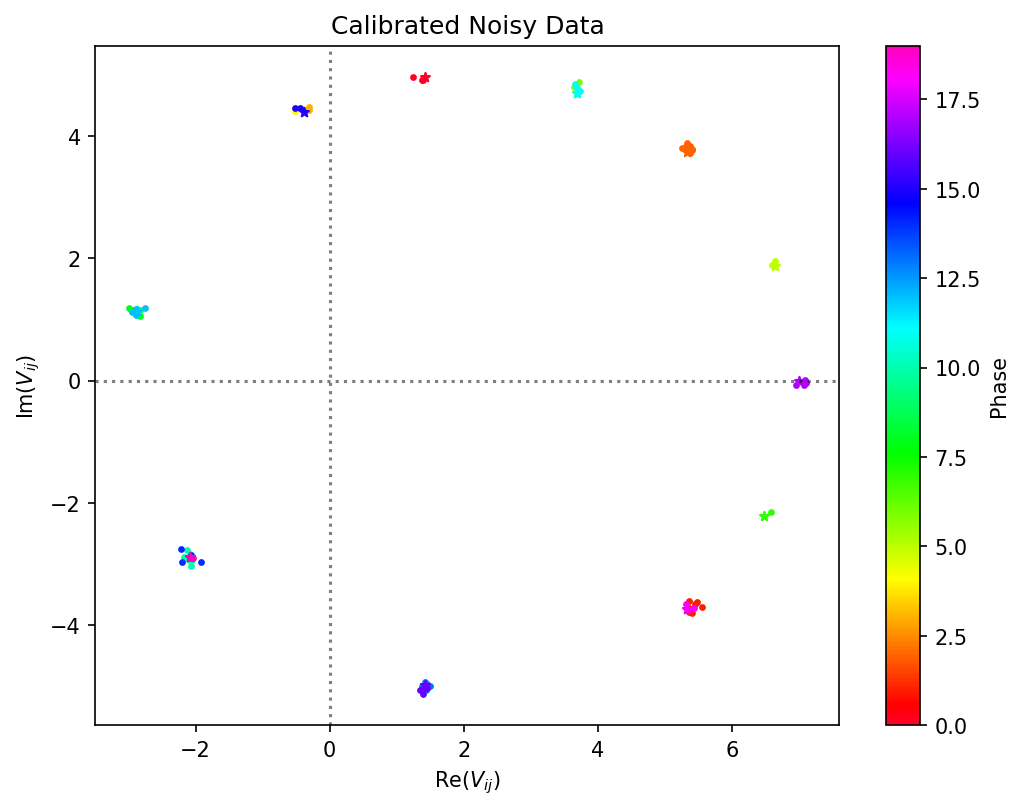

In [25]:
cal_data = sorted_data / (fit[ant_1_inds] * fit[ant_2_inds].conj())
# cmap = plt.cm.twilight
# norm = plt.cm.colors.Normalize(vmin=-np.pi,vmax=np.pi)
cmap = plt.cm.gist_rainbow
norm = plt.cm.colors.Normalize(vmin=0, vmax=len(edges)-2)
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.figure(figsize=(8,6),dpi=150,facecolor='w')
for i, (left, right) in enumerate(zip(edges, edges[1:])):
    grp_data = cal_data[left:right]
    grp_data_uncal = sorted_data[left:right]
    grp_uvw = sorted_uvws[left:right].mean(axis=0)
    true_vis = np.sum(src_flux * np.exp(-2j * np.pi * grp_uvw @ src_loc.T))
    angle = np.angle(true_vis)
#     color = cmap(norm(angle))
    color = cmap(norm(i))
    plt.scatter(grp_data.real, grp_data.imag, color=color, marker='.', s=20)#, label=f"Group {i}")
#     plt.scatter(grp_data_uncal.real, grp_data_uncal.imag, color=color, marker='+', s=20)
    plt.scatter(true_vis.real, true_vis.imag, color=color, marker='*', s=20)
cbar = plt.colorbar(smap)
cbar.set_label("Phase")
plt.xlabel(r"Re$(V_{ij})$")
plt.ylabel(r"Im$(V_{ij})$")
plt.title("Calibrated Noisy Data")
plt.axvline(0, ls=':', color='k', alpha=0.5)
plt.axhline(0, ls=':', color='k', alpha=0.5)
# plt.legend(ncol=3);
# plt.savefig("calibrated_noisy_data_two_src_one_at_zenith.png", dpi=150, bbox_inches="tight")

In [35]:
np.linalg.inv?

In [26]:
np.std(fit.real), np.std(fit.imag), noise_amp

(0.003437740790699115, 0.005902804429657865, 0.008012697126076676)

In [27]:
chisqs = [nll(step, *args) for step in steps]

In [28]:
# split_data, noise, split_cov, ant_1_inds, ant_2_inds, norm, gain_scale, grad_scale, edges

In [29]:
true_gains = np.zeros(2*n_ants)
true_gains[:n_ants] = 1
nll(true_gains, split_data, noise, split_cov, ant_1_inds, ant_2_inds, norm=None)

64.0353225438389

In [30]:
nll(fit_gains, split_data, noise, split_cov, ant_1_inds, ant_2_inds, norm=None)

Chi-squared isn't purely real.


0.11839341140369644

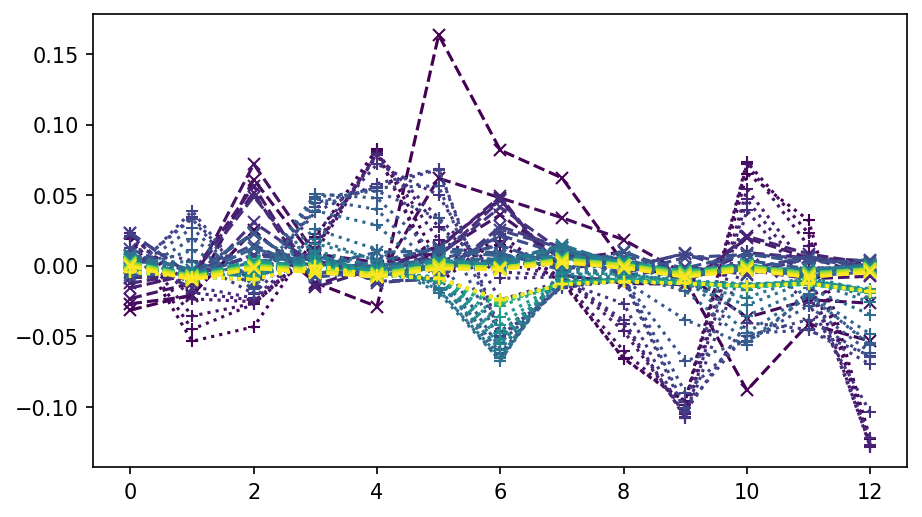

In [31]:
plt.figure(figsize=(7,4),dpi=150)
cnt = len(steps)
cmap = plt.cm.viridis
norm = plt.cm.colors.Normalize(vmin=0,vmax=cnt-1)
for i, step in enumerate(steps):
    g = step / gain_scale
    c = cmap(norm(i))
    plt.plot(g[:n_ants].real - 1, ls='--', marker='x', color=c)
    plt.plot(g[n_ants:].real, ls=':', marker='+', color=c)

In [32]:
def numerical_grad_nll(gains, data, noise, cov, ant_1_inds, ant_2_inds, norm="simple", scale=1, grad_scale=1, edges=None, dg_re=0.0001, dg_im=0.0001):
    """Calculate negative log-likelihood gradient numerically.
    
    data/cov should be SplitX quantities
    gains should be split, but the actual numpy array needs to be provided
    dg_x are step sizes
    """
    gradient = np.zeros_like(gains)
    n_ants = gains.size // 2
    for ant in range(n_ants):
        new_gains = gains.copy()
        new_gains[ant] += dg_re
        nll_above = nll(new_gains, data, noise, cov, ant_1_inds, ant_2_inds, norm=norm, scale=scale)
        new_gains[ant] -= 2*dg_re
        nll_below = nll(new_gains, data, noise, cov, ant_1_inds, ant_2_inds, norm=norm, scale=scale)
        gradient[ant] = 0.5 * (nll_above-nll_below) / dg_re
        new_gains = gains.copy()
        new_gains[n_ants+ant] += dg_im
        nll_above = nll(new_gains, data, noise, cov, ant_1_inds, ant_2_inds, norm=norm, scale=scale)
        new_gains[n_ants+ant] -= 2*dg_im
        nll_below = nll(new_gains, data, noise, cov, ant_1_inds, ant_2_inds, norm=norm, scale=scale)
        gradient[n_ants+ant] = 0.5 * (nll_above-nll_below) / dg_im
    return gradient

In [33]:
# Test numerical vs analytic gradient.
norm = "det"
analytic_gradient = grad_nll(
    corrcal.linalg.SplitVec(gains).data,
    split_data,
    noise,
    split_cov,
    ant_1_inds,
    ant_2_inds,
    norm=norm,
    scale=1,
)
numerical_gradient = numerical_grad_nll(
    corrcal.linalg.SplitVec(gains).data,
    split_data,
    noise,
    split_cov,
    ant_1_inds,
    ant_2_inds,
    norm=norm,
    scale=1,
    dg_re=0.0001,
    dg_im=0.0001,
)

Text(0, 0.5, 'Negative Log-Likelihood Gradient')

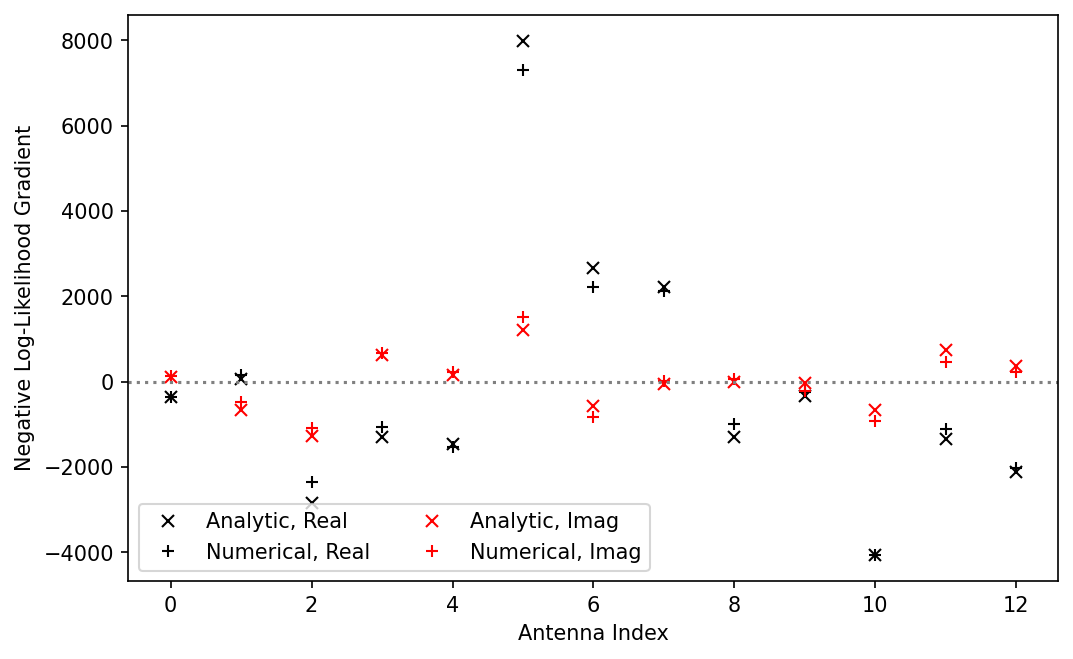

In [34]:
plt.figure(figsize=(8,5),dpi=150, facecolor='white')
plt.plot(analytic_gradient[:n_ants], 'kx', label='Analytic, Real')
plt.plot(numerical_gradient[:n_ants], 'k+', label='Numerical, Real')
plt.plot(analytic_gradient[n_ants:], 'rx', label='Analytic, Imag')
plt.plot(numerical_gradient[n_ants:], 'r+', label='Numerical, Imag')
plt.axhline(0, color='gray', ls=':')
plt.legend(ncol=2)
plt.xlabel("Antenna Index")
plt.ylabel("Negative Log-Likelihood Gradient")
# plt.savefig(f"numerical_vs_analytic_gradient_{norm}_norm_with_noise_two_src_one_at_zenith.png", dpi=150, bbox_inches='tight')

## TODOs
* Experiment with choice of scale factor. Use a logarithmic range of amplitudes and a linear range of phases from $[0,2\pi)$.
  * Make the following heatmaps as functions of scale factor parameters:
    * $\chi^2$
    * $N_{\rm iter}$
    * $\langle\Delta\chi^2\rangle$
    * $\langle g_{\rm fit} - g_{\rm true} \rangle$ (might be redundant)
    * $\chi^2/N_\nu$
* Compare solutions with rephasing and without rephasing.
* Figure out why things don't seem to want to work when using the determinant for normalization.